# LXE Solving
Here we solve for muons creating sound waves in liquid xenon. This is going to be great!

In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as const
from fem import *

# Load the text file with the properties of Xenon
prop_Xe = get_properties('./fluids/LXE.txt')
prop_mu = get_properties('./particles/muon.txt')

# Now we will define the appropriate constants in SI units
K       = prop_Xe['bulk_modulus']
c       = prop_Xe['sound_speed']
Cp      = prop_Xe['specific_heat_p']
beta    = prop_Xe['thermal_expansion']
mu      = prop_Xe['viscocity']
rho_0   = prop_Xe['rest_density']
I       = prop_Xe['ionization_potential']
Z       = prop_Xe['atomic_number']
M       = prop_Xe['molar_mass']
n       = rho_0/M*const.Avogadro                        # Particle density
s       = n**(-1/3)                                     # Inter-particle distance 
v       = prop_mu['speed']                              # Speed of particle
z       = prop_mu['charge']/const.elementary_charge     # Numer Charge of compound
cc      = const.c                                       # Speed of light
ne      = const.Avogadro * Z * rho_0/M                  # Electron Densiry
me      = const.electron_mass                           # Electron Mass
e       = -const.elementary_charge                      # Electron Charge
e0      = const.epsilon_0                               # Permitivity
bb      = v/cc                                          # Particle Relative speed

# dE/dx the bethe bloch formula for the particle
dEdx    = 4*np.pi/me * ne * z**2/v**2 *(e**2/(4*np.pi*e0))**2* (np.log(2*me*v**2/(I*(1-bb**2))) - bb**2)

# Control Constants
# They are scaling factors for the nondimensionalization
# To be altered each time so that to assist with the process
lam = 1e3
tau = 1e-1

# Derived constants
w0      = K/mu                              # Attenuation Frequency
T       = tau/w0                            # Standard Time unit
L       = lam*T*c                           # Standard Length unit
P       = beta*v**2*L**3*T/(s**5*Cp)*dEdx   # Standard Pressure Unit

# Nondimensionalized source function
t0 = 2e-4
f  = lambda r,z,t: (z-v*(t-t0)*T/L) * np.exp(-(L/s)**2/2 *(r**2+ (z-v*(t-t0)*T/L)**2))*1e4

In [2]:
# Here are the values for some characteristic constants for Xenon
print('''Physical Constants
--------------------------------------------''')
print('w0\t= %.3e Hz'%w0)
print('s\t= %.3e m'%s)
print('c\t= %.3e m/s'%c)
print('''
Simulation Constants
--------------------------------------------''')
print('T\t= %.3e s'%T)
print('L\t= %.3e m'%L)
print('P\t= %.3e Pa'%P)
print('''
Characteristic Source Constants
--------------------------------------------''')
print('std\t= %.3e L'%(s/L))
print('v\t= %.3e L/T'%(v*T/L))

Physical Constants
--------------------------------------------
w0	= 7.451e+10 Hz
s	= 4.189e-09 m
c	= 6.535e+02 m/s

Simulation Constants
--------------------------------------------
T	= 1.342e-12 s
L	= 8.770e-07 m
P	= 1.464e+10 Pa

Characteristic Source Constants
--------------------------------------------
std	= 4.776e-03 L
v	= 1.835e+02 L/T


In [3]:
vb = 1e1
sb = 1e-4
LL = s/sb
TT = s/v * vb/sb
Llam = v/c/vb
Ttau =  w0 * s/v * vb/sb

print('L\t= %.3e'%LL)
print('T\t= %.3e'%TT)
print('lam\t= %.3e'%Llam)
print('tau\t= %.3e'%Ttau)

L	= 4.189e-05
T	= 3.493e-12
lam	= 1.835e+04
tau	= 2.603e-01


In [4]:
# Now we have everything to create our numerical scheme so let's start

# Control variables
# These are the variables that control our simulation.
bounds  = [(0,1e-1),(0,1e-1)]           # Domain bounds
h       = 1e-3                          # Mesh Fineness parameter
FF      = lambda r,z: abs(r)            # Discretisation function
dt      = 2e-5                          # Simulation time step  

# Now we will get the mesh and points
points,mesh = get_mesh_grid(h,bounds)
# points,mesh = get_mesh(h,FF,bounds)
boundary    = get_boundary(points,bounds)

# Buld T, S matrices
TT,SS = get_TS(points,mesh)

# Construct the scheme matrix and apply boundary conditions
Ap= get_scheme_matrix(dt,TT,SS,tau=tau,lam=lam)
A = set_bc_lhs(boundary,Ap,points,mesh)

# Define the initial condition vectors
U_curr = np.zeros(len(points))
U_prev = np.zeros(len(points))
F      = np.array([0*f(*point,0*dt) for point in points])

ValueError: Contour levels must be increasing

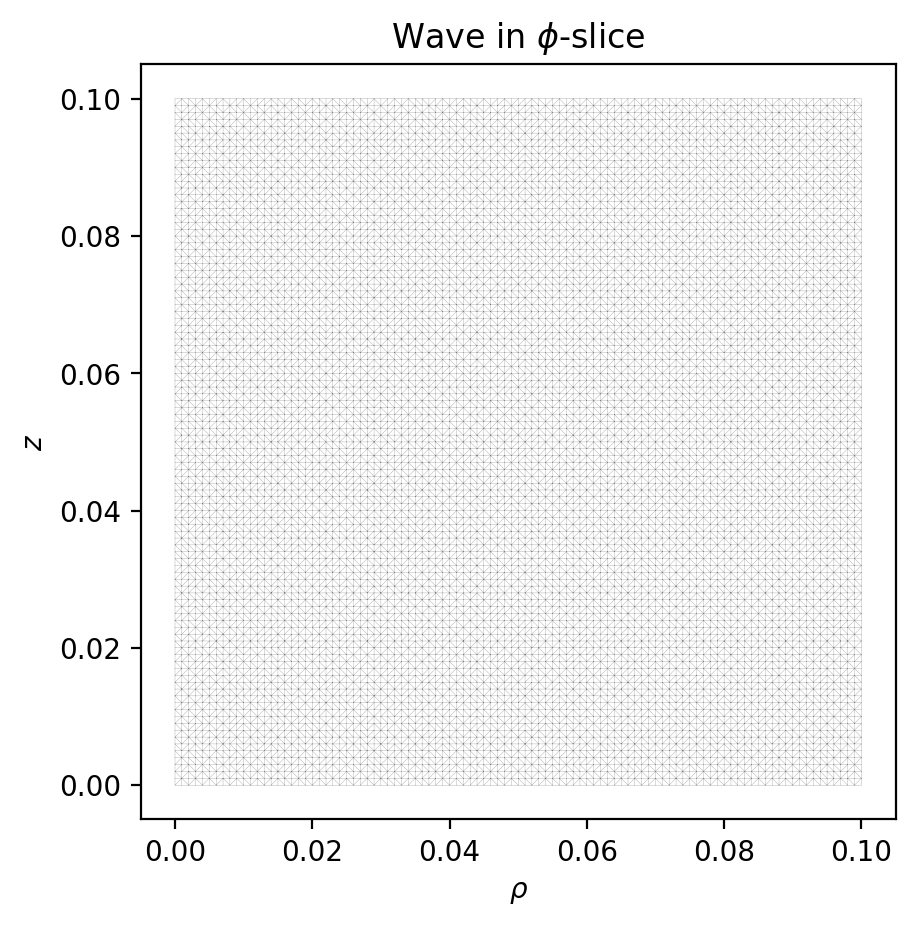

In [5]:
plot_U(points,mesh,F)

In [6]:
np.linalg.det(A.toarray())

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/linalg/linalg.py:2116: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


inf

In [7]:
# Check if the system has a solution using the Moore Penrose Inverse
# It will take approximately 600s to run. So grab a coffee

AA = A.toarray()
AP = np.linalg.pinv(AA)

AS = np.matmul(AA,AP)

D = [AS[i][i] for i in range(0,len(AS))]
print(np.where(D!=1))

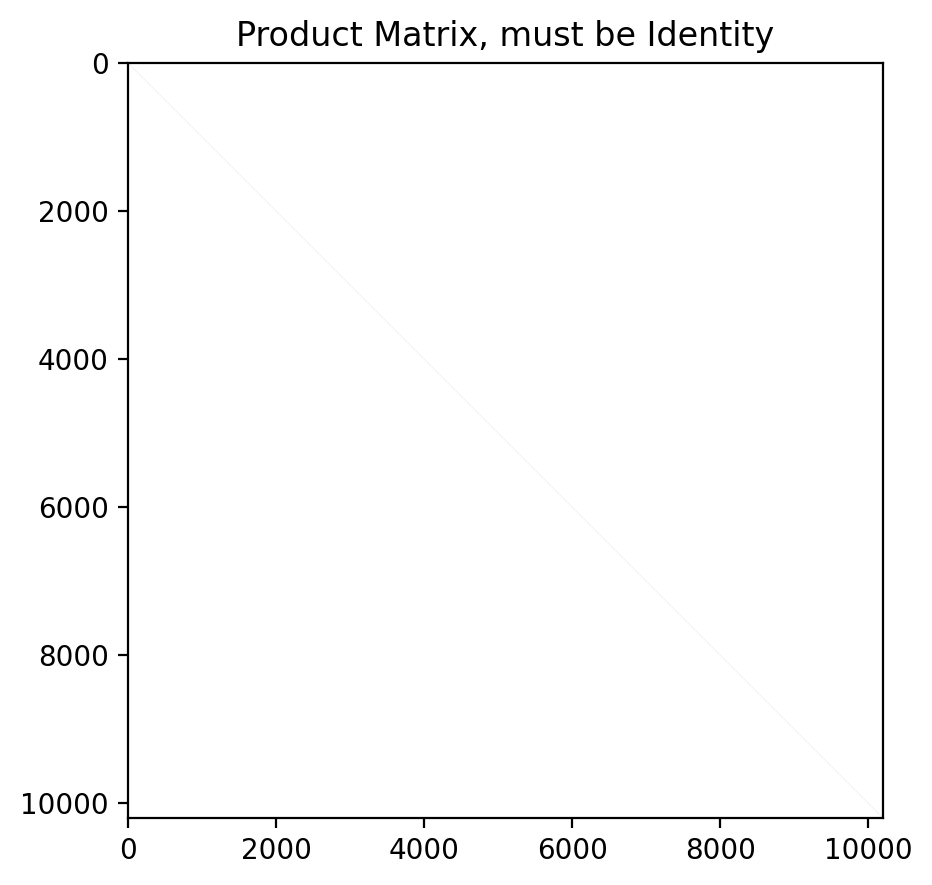

In [9]:
# Create a figure 
fig = plt.figure(figsize=(5,5),dpi=200)
ax = fig.add_subplot(111)
ax.set_title('Product Matrix, must be Identity')

# Plot the matrix
ax.imshow(AS,cmap=cm.binary)

In [18]:
# Let's take one step in time and plot

U_curr = run(2*dt,dt,A,SS,TT,U_curr,U_prev,f,points,tau=tau,lam=lam);
plot_U(points,mesh,U_curr)

# U_curr, U_prev = step(dt,A,SS,TT,U_curr,U_prev,F,tau=tau,lam=lam,boundary=boundary)
# plot_U(points,mesh,U_curr)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:206: MatrixRankWarning: Matrix is exactly singular
  warn("Matrix is exactly singular", MatrixRankWarning)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

ValueError: z array must not contain non-finite values within the triangulation

In [20]:
print(U_curr)
AI = np.linalg.inv(A.todense())

[nan nan nan ... nan nan nan]


LinAlgError: Singular matrix

In [15]:
# Calculate the left hand side
B = get_rhs(3*dt,SS,TT,U_curr,U_prev,F,tau=tau,lam=lam,boundary=boundary)
set_bc_rhs(boundary,B)

# move one step
U_prev = U_curr.copy()
U_curr = np.linalg.solve(A.todense(),B)

In [16]:
print(U_curr)

[ 0. -0.  0. ...  0.  0.  0.]


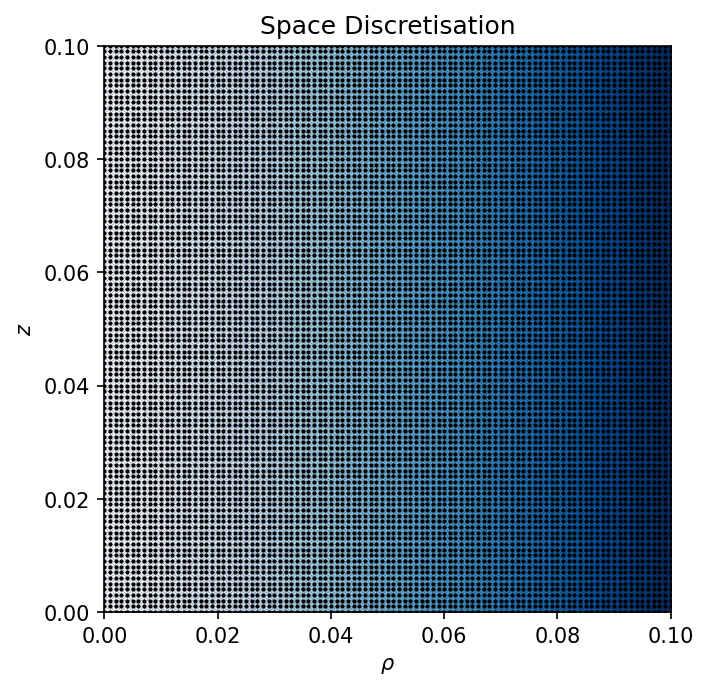

In [7]:
plot_mesh(points,mesh,FF,bounds=bounds);

ValueError: Contour levels must be increasing

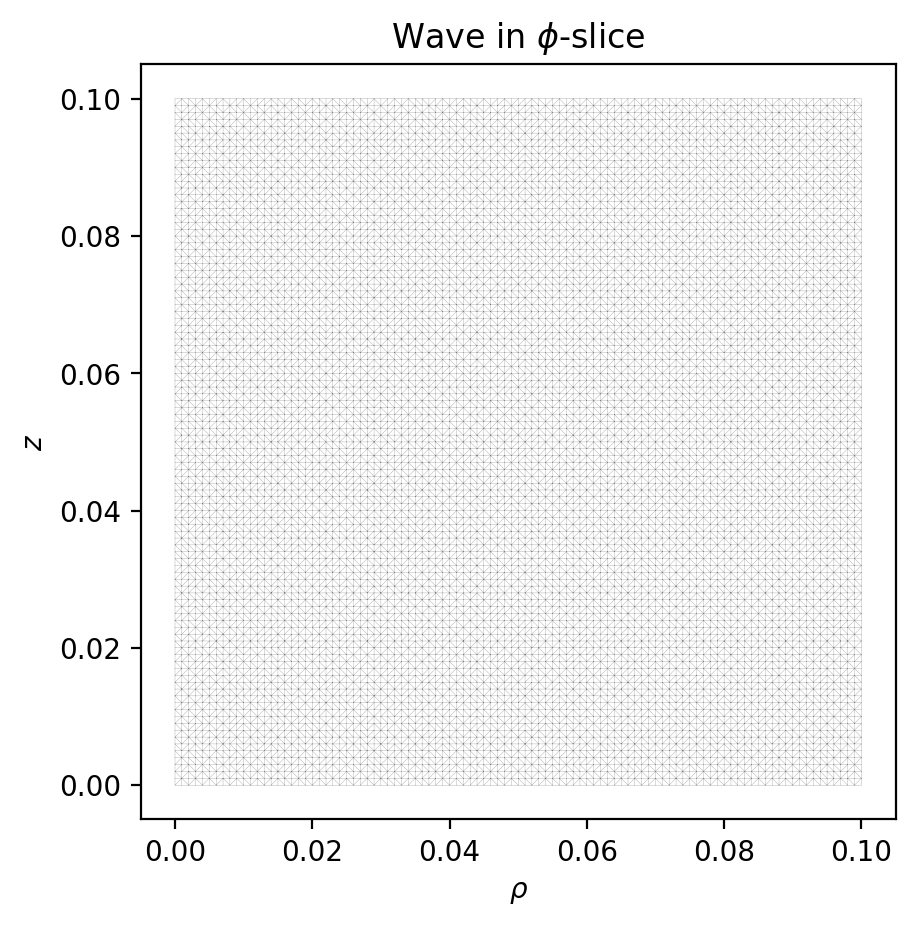

In [12]:
plot_U(points,mesh,U_prev)

In [8]:
%matplotlib widget
plot_A(A.toarray());

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

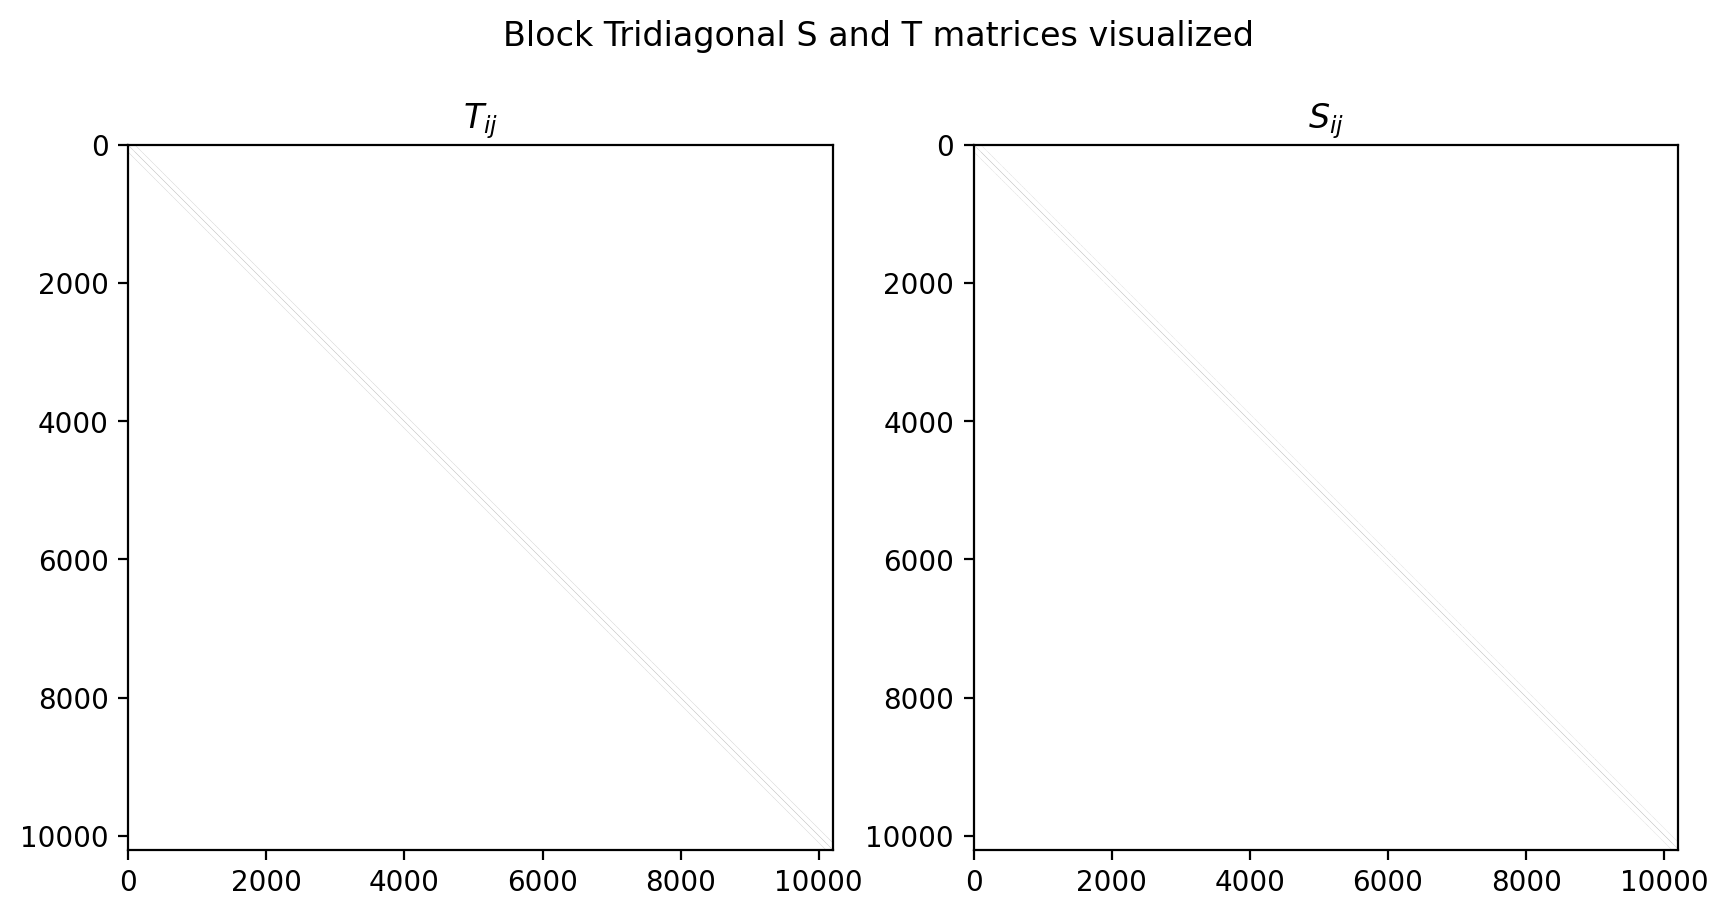

(<Figure size 2000x1000 with 2 Axes>,
 <AxesSubplot:title={'center':'$T_{ij}$'}>,
 <AxesSubplot:title={'center':'$S_{ij}$'}>)

In [ ]:
plot_TS(SS,TT)

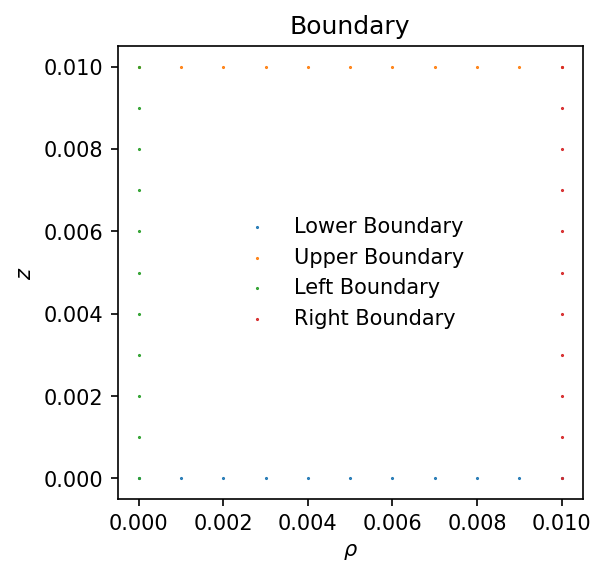

(<Figure size 600x600 with 1 Axes>,
 <AxesSubplot:title={'center':'Boundary'}, xlabel='$\\rho$', ylabel='$z$'>)

In [ ]:
plot_boundary(boundary,points)